# Travelling Salesman Problem
The Travelling Salesman Problem (TSP) is a classic combinatorial optimization problem in computer science and operations research.
🧠 Definition
Given a list of cities and the distances between each pair of cities, the goal of TSP is to find the shortest possible route that:

- Visits each city exactly once, and
- Returns to the starting city.

📌 Real-World Applications
- Route planning for delivery trucks or couriers
- Circuit board manufacturing (minimizing wire length)
- DNA sequencing
- Travel itinerary optimization
- Robotics and drone path planning

Generation 0: Best distance = 612.98
Generation 50: Best distance = 459.99
Generation 100: Best distance = 459.99
Generation 150: Best distance = 459.99
Generation 200: Best distance = 459.99
Generation 250: Best distance = 459.99
Generation 300: Best distance = 459.99
Generation 350: Best distance = 459.99
Generation 400: Best distance = 459.99
Generation 450: Best distance = 459.99
Generation 499: Best distance = 459.99


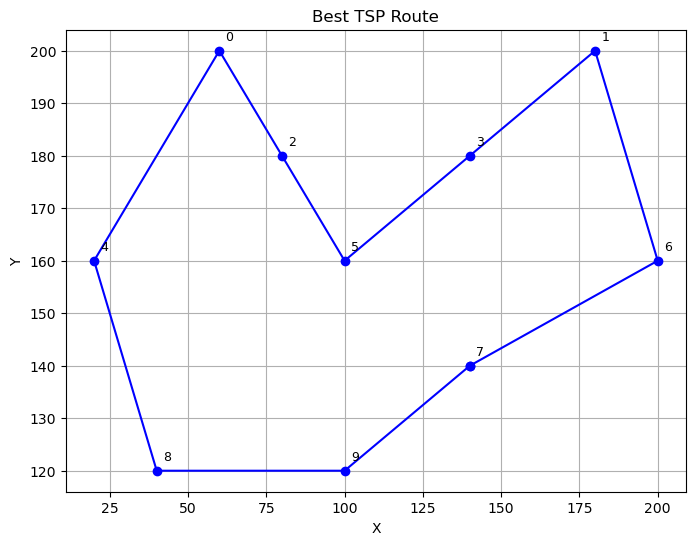

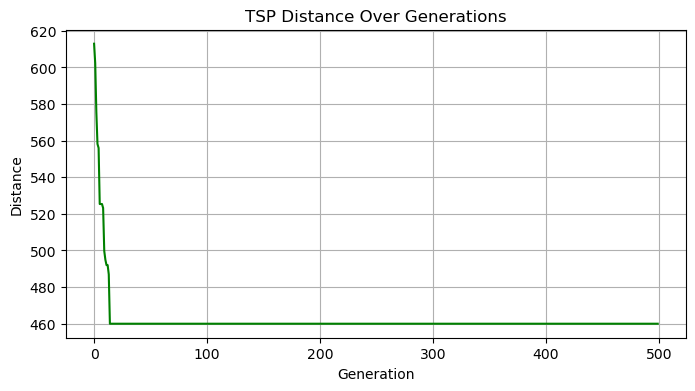

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# --------- Define TSP Problem ---------

# Example: coordinates of 10 cities
city_coords = [
    (60, 200), (180, 200), (80, 180), (140, 180),
    (20, 160), (100, 160), (200, 160), (140, 140),
    (40, 120), (100, 120)
]

# Calculate Euclidean distance between two cities
def distance(city1, city2):
    return np.linalg.norm(np.array(city1) - np.array(city2))

# Create distance matrix
def create_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = distance(cities[i], cities[j])
    return dist_matrix

distance_matrix = create_distance_matrix(city_coords)

# --------- Genetic Algorithm ---------

# Create a random route (permutation of cities)
def create_route(city_list):
    route = list(range(len(city_list)))
    random.shuffle(route)
    return route

# Create initial population
def initial_population(pop_size, city_list):
    return [create_route(city_list) for _ in range(pop_size)]

# Fitness = 1 / route length
def route_distance(route, dist_matrix):
    distance = 0
    for i in range(len(route)):
        from_city = route[i]
        to_city = route[(i + 1) % len(route)]
        distance += dist_matrix[from_city][to_city]
    return distance

def rank_routes(population, dist_matrix):
    return sorted([(route, route_distance(route, dist_matrix)) for route in population], key=lambda x: x[1])

# Selection
def selection(ranked_routes, elite_size):
    selection_results = [route for route, _ in ranked_routes[:elite_size]]
    fitness_scores = [1 / dist for _, dist in ranked_routes]
    probs = fitness_scores / np.sum(fitness_scores)
    selection_results += [ranked_routes[i][0] for i in np.random.choice(len(ranked_routes), len(ranked_routes) - elite_size, p=probs)]
    return selection_results

# Crossover (ordered crossover)
def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child_p1 = parent1[start:end]
    child_p2 = [city for city in parent2 if city not in child_p1]
    return child_p2[:start] + child_p1 + child_p2[start:]

# Mutation (swap cities)
def mutate(route, mutation_rate):
    for swapped in range(len(route)):
        if random.random() < mutation_rate:
            swap_with = int(random.random() * len(route))
            route[swapped], route[swap_with] = route[swap_with], route[swapped]
    return route

# Create new generation
def next_generation(current_gen, elite_size, mutation_rate, dist_matrix):
    ranked_routes = rank_routes(current_gen, dist_matrix)
    selection_results = selection(ranked_routes, elite_size)
    children = []

    # Elitism
    children.extend(selection_results[:elite_size])

    # Crossover and Mutation
    for i in range(elite_size, len(current_gen)):
        parent1 = random.choice(selection_results)
        parent2 = random.choice(selection_results)
        child = crossover(parent1, parent2)
        children.append(mutate(child, mutation_rate))
    
    return children, ranked_routes[0][1], ranked_routes[0][0]

# --------- Run Genetic Algorithm ---------

def genetic_algorithm(city_coords, pop_size=100, elite_size=20, mutation_rate=0.01, generations=500):
    dist_matrix = create_distance_matrix(city_coords)
    population = initial_population(pop_size, city_coords)
    progress = []

    for gen in range(generations):
        population, best_dist, best_route = next_generation(population, elite_size, mutation_rate, dist_matrix)
        progress.append(best_dist)
        if gen % 50 == 0 or gen == generations - 1:
            print(f"Generation {gen}: Best distance = {best_dist:.2f}")

    return best_route, best_dist, progress

# --------- Execute and Visualize ---------

best_route, best_distance, progress = genetic_algorithm(city_coords)

# Plot best route
def plot_route(route, cities, title="Best TSP Route"):
    x = [cities[i][0] for i in route + [route[0]]]
    y = [cities[i][1] for i in route + [route[0]]]
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', color='blue')
    for i, city in enumerate(route):
        plt.text(cities[city][0]+2, cities[city][1]+2, str(city), fontsize=9)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

# Plot progress
def plot_progress(progress):
    plt.figure(figsize=(8, 4))
    plt.plot(progress, color='green')
    plt.title("TSP Distance Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.show()

plot_route(best_route, city_coords)
plot_progress(progress)


In [3]:
# Required Libraries
import folium
from folium.plugins import AntPath
import numpy as np
import random
import matplotlib.pyplot as plt

# ------------------------------
# Step 1: Define Cities and Coordinates
# ------------------------------
cities = {
    'Colombo': (6.9271, 79.8612),
    'Galle': (6.0535, 80.2210),
    'Kandy': (7.2906, 80.6337),
    'Anuradhapura': (8.3114, 80.4037),
    'Jaffna': (9.6685, 80.0074)
}

city_names = list(cities.keys())
city_coords = list(cities.values())
N = len(city_names)

# ------------------------------
# Step 2: Calculate Distance Matrix using Haversine Formula
# ------------------------------
from math import radians, cos, sin, sqrt, atan2

def haversine(coord1, coord2):
    R = 6371  # Earth radius in km
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

distance_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        distance_matrix[i][j] = haversine(city_coords[i], city_coords[j])

# ------------------------------
# Step 3: Genetic Algorithm
# ------------------------------
def create_route(n): return random.sample(range(n), n)
def initial_population(pop_size, n): return [create_route(n) for _ in range(pop_size)]

def route_distance(route, dist_matrix):
    return sum(dist_matrix[route[i]][route[(i+1)%N]] for i in range(N))

def rank_routes(pop, dist_matrix):
    return sorted([(route, route_distance(route, dist_matrix)) for route in pop], key=lambda x: x[1])

def selection(ranked, elite_size):
    selected = [r for r, _ in ranked[:elite_size]]
    fitness = np.array([1/d for _, d in ranked])
    probs = fitness / fitness.sum()
    selected += [ranked[i][0] for i in np.random.choice(len(ranked), len(ranked) - elite_size, p=probs)]
    return selected

def crossover(p1, p2):
    start, end = sorted(random.sample(range(N), 2))
    child = p1[start:end]
    child += [city for city in p2 if city not in child]
    return child

def mutate(route, rate=0.01):
    for i in range(N):
        if random.random() < rate:
            j = random.randint(0, N-1)
            route[i], route[j] = route[j], route[i]
    return route

def next_generation(pop, elite_size, mutation_rate, dist_matrix):
    ranked = rank_routes(pop, dist_matrix)
    selected = selection(ranked, elite_size)
    children = selected[:elite_size]
    for i in range(elite_size, len(pop)):
        child = crossover(random.choice(selected), random.choice(selected))
        children.append(mutate(child, mutation_rate))
    return children, ranked[0][1], ranked[0][0]

def genetic_algorithm(dist_matrix, gens=200, pop_size=100, elite=10, mutation=0.02):
    pop = initial_population(pop_size, len(dist_matrix))
    best_progress = []
    for gen in range(gens):
        pop, best_dist, best_route = next_generation(pop, elite, mutation, dist_matrix)
        best_progress.append(best_dist)
        if gen % 50 == 0 or gen == gens - 1:
            print(f"Gen {gen}: Best distance = {best_dist:.2f} km")
    return best_route, best_dist, best_progress

best_route_idx, best_cost, progress = genetic_algorithm(distance_matrix)

# ------------------------------
# Step 4: Visualize Route on Folium Map
# ------------------------------
m = folium.Map(location=[7.5, 80.5], zoom_start=7)

ordered_cities = [city_names[i] for i in best_route_idx]
ordered_coords = [city_coords[i] for i in best_route_idx] + [city_coords[best_route_idx[0]]]

# Add markers
for i, name in enumerate(ordered_cities):
    folium.Marker(city_coords[best_route_idx[i]], popup=name).add_to(m)

# Add route line
AntPath(ordered_coords).add_to(m)

# Display the map
m


Gen 0: Best distance = 828.48 km
Gen 50: Best distance = 828.48 km
Gen 100: Best distance = 828.48 km
Gen 150: Best distance = 828.48 km
Gen 199: Best distance = 828.48 km


In [5]:
import folium
from folium.plugins import AntPath
import numpy as np
import random
from math import radians, cos, sin, sqrt, atan2

# Step 1: Define 10 Sri Lankan cities and coordinates
cities = {
    'Colombo': (6.9271, 79.8612),
    'Galle': (6.0535, 80.2210),
    'Kandy': (7.2906, 80.6337),
    'Anuradhapura': (8.3114, 80.4037),
    'Jaffna': (9.6685, 80.0074),
    'Trincomalee': (8.5874, 81.2152),
    'Nuwara Eliya': (6.9497, 80.7891),
    'Matara': (5.9485, 80.5353),
    'Batticaloa': (7.7102, 81.6924),
    'Ratnapura': (6.6828, 80.3992)
}

city_names = list(cities.keys())
city_coords = list(cities.values())
N = len(city_names)

# Step 2: Haversine formula to calculate distance matrix
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

distance_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        distance_matrix[i][j] = haversine(city_coords[i], city_coords[j])

# Step 3: Genetic Algorithm
def create_route(n): return random.sample(range(n), n)
def initial_population(pop_size, n): return [create_route(n) for _ in range(pop_size)]
def route_distance(route, dist_matrix):
    return sum(dist_matrix[route[i]][route[(i+1)%N]] for i in range(N))
def rank_routes(pop, dist_matrix):
    return sorted([(route, route_distance(route, dist_matrix)) for route in pop], key=lambda x: x[1])
def selection(ranked, elite_size):
    selected = [r for r, _ in ranked[:elite_size]]
    fitness = np.array([1/d for _, d in ranked])
    probs = fitness / fitness.sum()
    selected += [ranked[i][0] for i in np.random.choice(len(ranked), len(ranked) - elite_size, p=probs)]
    return selected
def crossover(p1, p2):
    start, end = sorted(random.sample(range(N), 2))
    child = p1[start:end]
    child += [city for city in p2 if city not in child]
    return child
def mutate(route, rate=0.01):
    for i in range(N):
        if random.random() < rate:
            j = random.randint(0, N-1)
            route[i], route[j] = route[j], route[i]
    return route
def next_generation(pop, elite_size, mutation_rate, dist_matrix):
    ranked = rank_routes(pop, dist_matrix)
    selected = selection(ranked, elite_size)
    children = selected[:elite_size]
    for i in range(elite_size, len(pop)):
        child = crossover(random.choice(selected), random.choice(selected))
        children.append(mutate(child, mutation_rate))
    return children, ranked[0][1], ranked[0][0]
def genetic_algorithm(dist_matrix, gens=300, pop_size=150, elite=20, mutation=0.02):
    pop = initial_population(pop_size, len(dist_matrix))
    best_progress = []
    for gen in range(gens):
        pop, best_dist, best_route = next_generation(pop, elite, mutation, dist_matrix)
        best_progress.append(best_dist)
        if gen % 50 == 0 or gen == gens - 1:
            print(f"Generation {gen}: Best distance = {best_dist:.2f} km")
    return best_route, best_dist, best_progress

# Step 4: Run the TSP Solver
best_route_idx, best_cost, progress = genetic_algorithm(distance_matrix)

# Step 5: Visualize on Folium Map
m = folium.Map(location=[7.5, 80.7], zoom_start=7)
ordered_cities = [city_names[i] for i in best_route_idx]
ordered_coords = [city_coords[i] for i in best_route_idx] + [city_coords[best_route_idx[0]]]

for i, name in enumerate(ordered_cities):
    folium.Marker(city_coords[best_route_idx[i]], popup=f"{i+1}. {name}").add_to(m)

AntPath(ordered_coords).add_to(m)
m.save("tsp_srilanka_map.html")
print("✅ Map saved as tsp_srilanka_map.html")


Generation 0: Best distance = 1370.07 km
Generation 50: Best distance = 1056.18 km
Generation 100: Best distance = 1056.18 km
Generation 150: Best distance = 1056.18 km
Generation 200: Best distance = 1056.18 km
Generation 250: Best distance = 1056.18 km
Generation 299: Best distance = 1056.18 km
✅ Map saved as tsp_srilanka_map.html
